## Data Transformation and Scaling
In this script we will be working with the airlines dataset by [OpenML](https://www.openml.org/search?type=data&sort=runs&id=1169). We will explore how to Log-transform data, how to convert integers to hours:minutes, and how to scale columns between 0 & 1.

In [ ]:
# Load libraries
from sklearn.datasets import fetch_openml
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning, message='divide by zero encountered in log10')

In [ ]:
# Fetch the Airlines dataset using sklearn
X, y = fetch_openml("airlines", version=1, as_frame=True, return_X_y=True)
# Convert to dataframe
df = pd.concat([X, y], axis=1)

# Sort values and add minutes to get AdjustedTime of minutes since start of week
df.sort_values(by=['DayOfWeek', 'Time'], inplace=True)
df['DayOfWeek'] = df['DayOfWeek'].astype(int)
df['Time'] = df['Time'].astype(int)
df['AdjustedTime'] = df['Time'] + (df['DayOfWeek'] - 1) * 1440

df.tail()

,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,AdjustedTime
449993,UA,24.0,PHX,ORD,7,1439,199.0,0,10079
449994,UA,78.0,HNL,SFO,7,1439,314.0,1,10079
449995,US,1442.0,LAX,PHL,7,1439,301.0,0,10079
449996,YV,2843.0,PHX,YUM,7,1439,66.0,0,10079
449997,YV,2882.0,PHX,FLG,7,1439,58.0,1,10079


In [ ]:
# Build integer to minutes function
def convert_time(time):
  hours = int(time / 60)
  minutes = int(time % 60)
  return f"{hours:02d}:{minutes:02d}"

# Convert departure and flight time into hours:minutes
df['Departure_Time'] = df['Time'].apply(convert_time)
df['Flight_Time'] = df['Length'].apply(convert_time)

df.head()

,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,AdjustedTime,Departure_Time,Flight_Time
85189,DL,2344.0,LAS,CVG,1,10,215.0,0,10,00:10,03:35
205551,DL,2344.0,LAS,CVG,1,10,215.0,0,10,00:10,03:35
328765,DL,2344.0,LAS,CVG,1,10,215.0,0,10,00:10,03:35
449998,DL,2344.0,LAS,CVG,1,10,215.0,0,10,00:10,03:35
85190,CO,269.0,SFO,IAH,1,15,205.0,1,15,00:15,03:25


In [ ]:
# Apply log transformation to relevant columns with large spread
df_log = df.copy()
for col in ['Length']:  # Replace with the column or columns you want to log-transform
    df_log[col] = np.log10(df_log[col])

df_log.head()

,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,AdjustedTime,Departure_Time,Flight_Time
85189,DL,2344.0,LAS,CVG,1,10,2.332438,0,10,00:10,03:35
205551,DL,2344.0,LAS,CVG,1,10,2.332438,0,10,00:10,03:35
328765,DL,2344.0,LAS,CVG,1,10,2.332438,0,10,00:10,03:35
449998,DL,2344.0,LAS,CVG,1,10,2.332438,0,10,00:10,03:35
85190,CO,269.0,SFO,IAH,1,15,2.311754,1,15,00:15,03:25


## Scale Columns

In [ ]:
# Create a new column for scaled flight time
df_log['Departure_Time_Scaled'] = MinMaxScaler().fit_transform(df_log['AdjustedTime'].values.reshape(-1, 1))

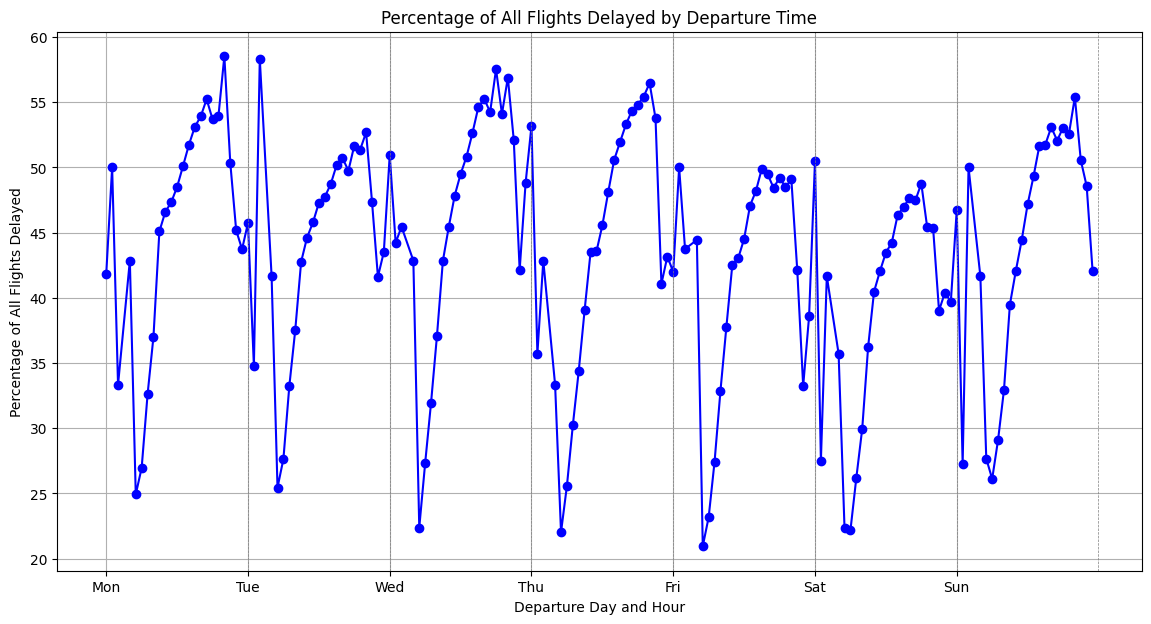

In [ ]:
# Convert AdjustedTime to hours
df_log['Departure_Time'] = df_log['AdjustedTime'] / 60

# Ensure the Delay column is of numeric type
df_log['Delay'] = pd.to_numeric(df_log['Delay'])

# Group by each hour and calculate the percentage of delayed flights
df_log['Hour'] = df_log['Departure_Time'].astype(int)
delay_percentage = df_log.groupby('Hour')['Delay'].mean() * 100

# Plot the line graph
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(delay_percentage.index, delay_percentage, marker='o', linestyle='-', color='b')

# Customizing the x-ticks
ax.set_xticks(np.arange(0, 24*7, 24))

# Setting custom x-tick labels
ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=0)

# Vertical lines to separate the days
for day in range(1, 8):
    plt.axvline(x=day*24, color='grey', linestyle='--', linewidth=0.5)

ax.set_xlabel('Departure Day and Hour')
ax.set_ylabel('Percentage of All Flights Delayed')
ax.set_title('Percentage of All Flights Delayed by Departure Time')
ax.grid(True)

In [ ]:
## End of Script